# Aggregating Population Change and Migration Types for Franklin and Delaware Counties from Census PEP data

## Introduction

This script is meant to take county-wide Census Pep data and filter for Franklin and Delaware from 2010-2021 and output two new agregated tables, one to focus on migration type and the other population change type, where the trends between the counties are combined.

### Process outline

The process carried out by this workflow can be described as follows:
  - The script will retrieve the Census PEP datasets from the local MORPC repo
  - Filter to only retain and sum records from Franklin or Delawre, Ohio 2010-2021
  - Identify and keep only the rows containing the maximum 'Vintage' for each 'Year'
  - Transform tables to aggregate migration information by type and aggregate population change information by type.
  - Write aggregated tables and stacked bar charts to Excel to distingush between international and domestic migration and another to distinguish between natrual population change and net migration

## Setup

### Import required packages

In [40]:
import csv
import os
import shutil
import json
from tableschema import Table
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append(os.path.normpath("../../morpc-common"))

### Parameters

In [41]:
# Assign a color to each of the expected bars in the chart using hex codes.
BAR_COLORS = {
    "NatChange": "#1f77b4",  # Mid blue
    "Migration": "#2ca02c",  # Light green
    "DomesticMig": "#ff7f0e",  # Another shade of blue or orange for distinction
    "InternationalMig": "#d62728"  # A different shade of green or red for distinction
}

# Specify the number formatting string to be used on the y-axis of the charts
# NUMBER_FORMAT_STRING = '[>=1000]#,##0,"K";'

# Define input and output directories
INPUT_DIR = "./input_data"
OUTPUT_DIR = "./output_data"

### Define inputs

#### Census Pep country wide table

In [42]:
CENSUSPEP_COUNTY_WIDE_TABLE_FILENAME = "censusPep_county_wide.csv"
CENSUSPEP_COUNTY_WIDE_TABLE_PATH = os.path.join(INPUT_DIR, CENSUSPEP_COUNTY_WIDE_TABLE_FILENAME)
CENSUSPEP_COUNTY_WIDE_TABLE_SCHEMA_FILENAME = CENSUSPEP_COUNTY_WIDE_TABLE_FILENAME.replace(".csv","_schema.json")
CENSUSPEP_COUNTY_WIDE_TABLE_SCHEMA_PATH = os.path.join(INPUT_DIR, CENSUSPEP_COUNTY_WIDE_TABLE_SCHEMA_FILENAME)
print("Data: {}".format(CENSUSPEP_COUNTY_WIDE_TABLE_PATH))
print("Schema: {}".format(CENSUSPEP_COUNTY_WIDE_TABLE_SCHEMA_PATH))

Data: ./input_data\censusPep_county_wide.csv
Schema: ./input_data\censusPep_county_wide_schema.json


### Define outputs
The following datasets will be produced by the process described in this notebook.

#### Franklin and Delaware counties migration by type and year (2010-2021)

In [43]:
MIGRATION_TABLE_FILENAME = "migration_aggregated_data.csv"
MIGRATION_TABLE_PATH = os.path.join(OUTPUT_DIR, MIGRATION_TABLE_FILENAME)
MIGRATION_TABLE_SCHEMA_FILENAME = MIGRATION_TABLE_FILENAME.replace(".csv","_schema.json")
MIGRATION_TABLE_SCHEMA_PATH = os.path.join(OUTPUT_DIR, MIGRATION_TABLE_SCHEMA_FILENAME)
print("Data: {}".format(MIGRATION_TABLE_PATH))
print("Schema: {}".format(MIGRATION_TABLE_SCHEMA_PATH))

Data: ./output_data\migration_aggregated_data.csv
Schema: ./output_data\migration_aggregated_data_schema.json


#### Franklin and Delaware counties population change by type and year (2010-2021)

In [44]:
POPCHANGE_TABLE_FILENAME = "popChange_aggregated_data.csv"
POPCHANGE_TABLE_PATH = os.path.join(OUTPUT_DIR, POPCHANGE_TABLE_FILENAME)
POPCHANGE_TABLE_SCHEMA_FILENAME = POPCHANGE_TABLE_FILENAME.replace(".csv","_schema.json")
POPCHANGE_TABLE_SCHEMA_PATH = os.path.join(OUTPUT_DIR, POPCHANGE_TABLE_SCHEMA_FILENAME)
print("Data: {}".format(POPCHANGE_TABLE_PATH))
print("Schema: {}".format(POPCHANGE_TABLE_SCHEMA_PATH))

Data: ./output_data\popChange_aggregated_data.csv
Schema: ./output_data\popChange_aggregated_data_schema.json


#### Compiled Excel sheet

In [45]:
OUTPUT_TABLE_FILENAME = "compiled.xlsx"
OUTPUT_TABLE_PATH = os.path.join(OUTPUT_DIR, OUTPUT_TABLE_FILENAME)
print("Output data path: {}".format(OUTPUT_TABLE_PATH))

Output data path: ./output_data\compiled.xlsx


## Create Census Pep table and schema in input path

### Copying Census Pep country wide table to input directory

In [46]:
# Adjust the path to where the .csv table and .json schema are located
table_path = "../morpc-censuspep-fetch/output_data/censusPep_county_wide.csv"

# Read the CSV file into a DataFrame
data = pd.read_csv(table_path)

# Save the census data to the input directory
data.to_csv(CENSUSPEP_COUNTY_WIDE_TABLE_PATH)

### Creating Census Pep country wide table schema to input directory with TableSchema

In [47]:
# Create table
table = Table(CENSUSPEP_COUNTY_WIDE_TABLE_PATH)

# Infer table variable types
table.infer()

# Convert missing values to 'N/A'
table.schema.descriptor['missingValues'] = 'N/A'
table.schema.commit()

# Save schema
table.schema.save(CENSUSPEP_COUNTY_WIDE_TABLE_SCHEMA_PATH)

### Converting input table variables from schema

In [48]:
# Load the schema from the JSON file
with open(CENSUSPEP_COUNTY_WIDE_TABLE_SCHEMA_PATH, 'r') as file:
    schema = json.load(file)

# Define a function to convert data types based on the schema
def convert_data_types(row, schema):
    converted_row = {}
    for field in schema['fields']:
        field_name = field['name']
        field_type = field['type']
        if field_name in row:
            if field_type == 'int':
                converted_row[field_name] = int(row[field_name])
            elif field_type == 'string':
                converted_row[field_name] = str(row[field_name])
            # Add more type conversions as needed
            else:
                converted_row[field_name] = row[field_name]  # Keep as is if type not recognized
    return converted_row

# Read the input data, apply conversion, and process it
converted_data = []

with open(CENSUSPEP_COUNTY_WIDE_TABLE_PATH, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        converted_row = convert_data_types(row, schema)
        converted_data.append(converted_row)

## Filtering for and combining Franklin, Ohio and Delaware, Ohio 2010-2021 with maximum vintage for each year

### Filter for maximum vintage for each year

In [49]:
# Step 1: Group by 'Year' and identify the maximum 'Vintage' for each 'Year'
max_vintage_per_year = data.groupby('Year')['Vintage'].transform("max")

# Step 2: Filter the original DataFrame to keep only rows with the maximum 'Vintage' for their 'Year'
data = data[data['Vintage'] == max_vintage_per_year]

### Filter for Ohio

In [50]:
# Filter for STNAME "Ohio"
data = data[data['STNAME'].isin(['Ohio'])]

### Filter for Delaware and Franklin counties

In [51]:
# Filter for CITYNAME "Delaware" and "Franklin"
data = data[data['CTYNAME'].isin(['Delaware', 'Franklin'])]

### Filter for 2010-2021

In [52]:
# Filter for Years between 2010-2021
data = data[(data['Year'] >= 2010) & (data['Year'] <= 2021)]

#Convert 'Year' variable type to Integer
data['Year'] = data['Year'].astype(int)
data.head()

,GEOID,STNAME,CTYNAME,Year,Vintage,BIRTHS,DEATHS,DOMESTICMIG,INTERNATIONALMIG,NATURALCHG,NETMIG,NPOPCHG,POPESTIMATE,RESIDUAL
33493,39041,Ohio,Delaware,2010,2019,557,249,527,70,308,597,927,175099,22
33497,39049,Ohio,Franklin,2010,2019,4506,1967,-630,930,2539,300,2726,1166202,-113
36635,39041,Ohio,Delaware,2011,2019,2093,923,2025,234,1170,2259,3436,178535,7
36639,39049,Ohio,Franklin,2011,2019,17857,8579,914,4408,9278,5322,14598,1180800,-2
39777,39041,Ohio,Delaware,2012,2019,2108,904,1111,288,1204,1399,2592,181127,-11


### Combine records between Franklin and Delaware counties for each year

In [53]:
# Group by 'YEAR' and calculate sums for the specified columns
data = data.groupby('Year').agg(
    Total_Births=pd.NamedAgg(column='BIRTHS', aggfunc='sum'),
    Total_Deaths=pd.NamedAgg(column='DEATHS', aggfunc='sum'),
    Total_DomesticMig=pd.NamedAgg(column='DOMESTICMIG', aggfunc='sum'),
    Total_InternationalMig=pd.NamedAgg(column='INTERNATIONALMIG', aggfunc='sum'),
    Total_NaturalChg=pd.NamedAgg(column='NATURALCHG', aggfunc='sum'),
    Total_NetMig=pd.NamedAgg(column='NETMIG', aggfunc='sum'),
    Total_NPopChg=pd.NamedAgg(column='NPOPCHG', aggfunc='sum'),
    Total_PopEstimate=pd.NamedAgg(column='POPESTIMATE', aggfunc='sum'),
    Total_Residual=pd.NamedAgg(column='RESIDUAL', aggfunc='sum')
).reset_index() 
data.head()

,Year,Total_Births,Total_Deaths,Total_DomesticMig,Total_InternationalMig,Total_NaturalChg,Total_NetMig,Total_NPopChg,Total_PopEstimate,Total_Residual
0,2010,5063,2216,-103,1000,2847,897,3653,1341301,-91
1,2011,19950,9502,2939,4642,10448,7581,18034,1359335,5
2,2012,20237,9469,4585,5555,10768,10140,20837,1380172,-71
3,2013,20791,9926,5614,7564,10865,13178,24086,1404258,43
4,2014,21122,9865,5784,6489,11257,12273,23544,1427802,14


## Creating migration change type table and schema

### Aggregation for migration type table

In [54]:
# Melt the DataFrame to "unpivot" the Total_DomesticMig and Total_InternationalMig columns
migration_data = pd.melt(data, id_vars=['Year'], value_vars=['Total_DomesticMig', 'Total_InternationalMig'], var_name='ChangeType', value_name='PopChange')

# Replace 'Total_DomesticMig' and 'Total_InternationalMig' with 'DomesticMig' and 'InternationalMig' respectively in the 'ChangeType' column
migration_data['ChangeType'] = migration_data['ChangeType'].map({'Total_DomesticMig': 'DomesticMig', 'Total_InternationalMig': 'InternationalMig'})

# Sort by 'Year'
migration_data_sorted = migration_data.sort_values(by='Year')

migration_data_sorted['ChangeType'] = migration_data_sorted['ChangeType'].replace('InternationalMig', 'International Migration')
migration_data_sorted['ChangeType'] = migration_data_sorted['ChangeType'].replace('DomesticMig', 'Domestic Migration')

# Save the 'grouped_data' DataFrame to output directory
migration_data_sorted.to_csv(MIGRATION_TABLE_PATH, index=False)

### Creating migration type table schema

In [55]:
# Create table
table = Table(MIGRATION_TABLE_PATH)

# Infer table variable types
table.infer()

# Convert missing values to 'N/A'
table.schema.descriptor['missingValues'] = 'N/A'
table.schema.commit()

# Save schema
table.schema.save(MIGRATION_TABLE_SCHEMA_PATH)

### Converting migration type table variables from schema

In [56]:
# Load the schema from the JSON file
with open(MIGRATION_TABLE_SCHEMA_PATH, 'r') as file:
    schema = json.load(file)

# Define a function to convert data types based on the schema
def convert_data_types(row, schema):
    converted_row = {}
    for field in schema['fields']:
        field_name = field['name']
        field_type = field['type']
        if field_name in row:
            if field_type == 'int':
                converted_row[field_name] = int(row[field_name])
            elif field_type == 'string':
                converted_row[field_name] = str(row[field_name])
            # Add more type conversions as needed
            else:
                converted_row[field_name] = row[field_name]  # Keep as is if type not recognized
    return converted_row

# Read the input data, apply conversion, and process it
converted_data = []

with open(MIGRATION_TABLE_PATH, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        converted_row = convert_data_types(row, schema)
        converted_data.append(converted_row)

In [58]:
# Preview migration change type table
df = pd.read_csv(MIGRATION_TABLE_PATH)
df.head()

,Year,ChangeType,PopChange
0,2010,Domestic Migration,-103
1,2010,International Migration,1000
2,2011,Domestic Migration,2939
3,2011,International Migration,4642
4,2012,Domestic Migration,4585


## Creating population change type table and schema

### Aggregation for population change type table

In [59]:
# Melt the DataFrame to "unpivot" the Total_NaturalChg and Total_NetMig columns
popChange_data = pd.melt(data, id_vars=['Year'], value_vars=['Total_NaturalChg', 'Total_NetMig'], var_name='ChangeType', value_name='PopChange')

# Replace 'Total_NaturalChg' and 'Total_NetMig' with 'NatChange' and 'Migration' respectively in the 'ChangeType' column
popChange_data['ChangeType'] = popChange_data['ChangeType'].map({'Total_NaturalChg': 'NatChange', 'Total_NetMig': 'Migration'})

# Sort by 'Year'
popChange_data_sorted = popChange_data.sort_values(by='Year')

popChange_data_sorted['ChangeType'] = popChange_data_sorted['ChangeType'].replace('NatChange', 'Natural Change')

# Save the 'grouped_data' DataFrame to output directory
popChange_data_sorted.to_csv(POPCHANGE_TABLE_PATH, index=False)

### Creating population change type table type schema

In [60]:
# Create table
table = Table(POPCHANGE_TABLE_PATH)

# Infer table variable types
table.infer()

# Convert missing values to 'N/A'
table.schema.descriptor['missingValues'] = 'N/A'
table.schema.commit()

# Save schema
table.schema.save(POPCHANGE_TABLE_SCHEMA_PATH)

### Converting population change table variables from schema

In [61]:
# Load the schema from the JSON file
with open(POPCHANGE_TABLE_SCHEMA_PATH, 'r') as file:
    schema = json.load(file)

# Define a function to convert data types based on the schema
def convert_data_types(row, schema):
    converted_row = {}
    for field in schema['fields']:
        field_name = field['name']
        field_type = field['type']
        if field_name in row:
            if field_type == 'int':
                converted_row[field_name] = int(row[field_name])
            elif field_type == 'string':
                converted_row[field_name] = str(row[field_name])
            # Add more type conversions as needed
            else:
                converted_row[field_name] = row[field_name]  # Keep as is if type not recognized
    return converted_row

# Read the input data, apply conversion, and process it
converted_data = []

with open(POPCHANGE_TABLE_PATH, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        converted_row = convert_data_types(row, schema)
        converted_data.append(converted_row)

In [62]:
# Preview population change type table
df = pd.read_csv(POPCHANGE_TABLE_PATH)
df.head()

,Year,ChangeType,PopChange
0,2010,Natural Change,2847
1,2010,Migration,897
2,2011,Natural Change,10448
3,2011,Migration,7581
4,2012,Natural Change,10768


## Writing data and charts to Excel file

In [63]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(OUTPUT_TABLE_PATH, engine='xlsxwriter')    

# Read the CSV files
popchange_df = pd.read_csv(POPCHANGE_TABLE_PATH)
migration_df = pd.read_csv(MIGRATION_TABLE_PATH)

# Pivot the DataFrames
popchange_pivot = popchange_df.pivot(index='Year', columns='ChangeType', values='PopChange').reset_index()
migration_pivot = migration_df.pivot(index='Year', columns='ChangeType', values='PopChange').reset_index()

# Write the pivoted DataFrames to separate sheets
popchange_pivot.to_excel(writer, sheet_name='Population Change by Type', index=False)
migration_pivot.to_excel(writer, sheet_name='Migration Change by Type', index=False)

workbook = writer.book

# Helper function to add charts
def add_stacked_bar_chart(worksheet_name, dataframe, workbook):
    worksheet = writer.sheets[worksheet_name]
    chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
    
    for i in range(1, len(dataframe.columns)):
        chart.add_series({
            'name':       [worksheet_name, 0, i],
            'categories': [worksheet_name, 1, 0, len(dataframe), 0],
            'values':     [worksheet_name, 1, i, len(dataframe), i],
        })
    
    chart.set_title({'name': worksheet_name})
    chart.set_x_axis({'name': 'Year'})
    chart.set_y_axis({'name': 'Population Change', 'major_gridlines': {'visible': False}})
    chart.set_legend({
        'position': 'bottom',
        'font': {'name': 'Arial'}    
    })
    worksheet.set_column('A:A', 15)
    worksheet.insert_chart('G2', chart)

# Add charts for each sheet
add_stacked_bar_chart('Population Change by Type', popchange_pivot, workbook)
add_stacked_bar_chart('Migration Change by Type', migration_pivot, workbook)


# Close the Pandas Excel writer and output the Excel file
writer.close()

## Creating Charts

### Creating stacked bar chart for migration type

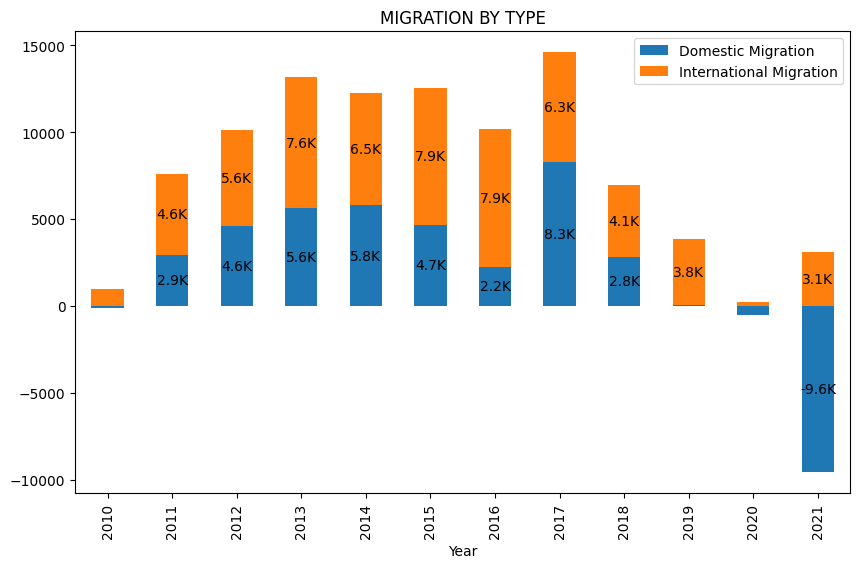

In [64]:
# Pivot the DataFrame to have 'Year' as the index, 'ChangeType' as the columns, and 'PopChange' as the values
pivoted_migration_data = migration_data_sorted.pivot(index='Year', columns='ChangeType', values='PopChange').fillna(0)

# Rename the columns for the legend
pivoted_migration_data.columns = ['Domestic Migration', 'International Migration']

# Plot the stacked bar chart
ax=pivoted_migration_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding labels to each bar, omitting labels for values less than 1.5K
for container in ax.containers:
    labels = [f'{x/1000:.1f}K' if abs(x) >= 1500 else '' for x in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center')
plt.title('MIGRATION BY TYPE')

# Show the plot
plt.show()

### Creating stacked bar chart for population change type

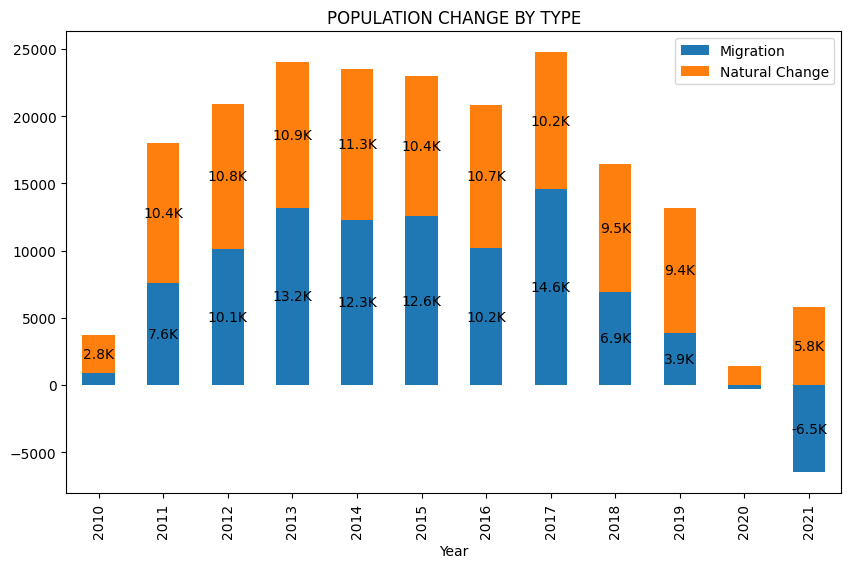

In [65]:
# Pivot the DataFrame to have 'Year' as the index, 'ChangeType' as the columns, and 'PopChange' as the values
pivoted_popChange_data = popChange_data_sorted.pivot(index='Year', columns='ChangeType', values='PopChange').fillna(0)

# Rename the columns for the legend
pivoted_popChange_data.columns = ['Migration', 'Natural Change']

# Plot the stacked bar chart
ax= pivoted_popChange_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding labels to each bar, omitting labels for values less than 1.5K
for container in ax.containers:
    labels = [f'{x/1000:.1f}K' if abs(x) >= 1500 else '' for x in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center')

plt.title('POPULATION CHANGE BY TYPE')

# Show the plot
plt.show()